# Plotting MODFLOW results
This tutorial will walk through some basic plotting using Flopy and Matplotlib. Plotting is described in the Flopy documentation [here](https://modflowpy.github.io/flopydoc/). However, [these](https://github.com/modflowpy/flopy/blob/develop/docs/notebook_examples.md) example Jupyter notebooks are more useful.

---

## 1. Import packages and define variables we need

In [1]:
#Import packages
import os
import flopy
import numpy as np
import pandas as pd
import matplotlib as mp          #tool for plotting
import matplotlib.pyplot as plt  #necessary tool for creating and formatting plots
import flopy.utils.binaryfile as bf

#Import specific tools
from mpl_toolkits.mplot3d import Axes3D  #allows us to plot in 3D
from matplotlib import cm  #import color maps
from matplotlib.ticker import LinearLocator, FormatStrFormatter  #set ticks on axes and format them

#Jupyter specific--included to show plots in notebook
%matplotlib inline 


#---------------------
#Load in model object
modelname = "example_model"  #model name
m = flopy.modflow.Modflow.load(modelname+'.nam')  #load in the example model

#Variables we need 
## Discretization
nrow = 50        #number of rows
ncol = 50        #number of columns
dx = 100.        #width in x
dy = 100.        #width in y
nlay = 1         #number of layers
Lx = dx*ncol     #length of domain in x
Ly = dy*nrow     #length of domain in y

## Timing
nper = 4  #number of stress periods 

## ET
ET = 5e-3 #m/day
ET_locxy=[[0, 0], [5000, 5000]]  #lower left and upper right corners of ET in xy coordinates
extinction_depth = 20 #m

ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy))  #convert the y locations to rows
ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))            #convert the y locations to rows
ET_zone = np.zeros((nlay,nrow,ncol))                                         #define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET  #assign ET rate to the ET zone

## Recharge
recharge = 3e-4 #m/day
rech_locxy=[[0, 4000], [5000, 5000]] #lower left and upper right corners of recharge in xy coordinates

rech_rows=(np.floor(nrow-rech_locxy[1][1]/dy),np.floor(nrow-rech_locxy[0][1]/dy))  #convert the y locations to rows
rech_cols=(np.floor(rech_locxy[0][0]/dx),np.floor(rech_locxy[1][0]/dx))            #convert the x locations to cols
rech_zone = np.zeros((nlay,nrow,ncol))                                             #define an array of zeroes the size of the model grid
rech_zone[0,int(rech_rows[0]):int(rech_rows[1]), int(rech_cols[0]):int(rech_cols[1])] = recharge  #assign rech rate to the rech zone

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


## 2. Read in Budget data
Refer to the Water_budget_tutorial (contained in this repo) for more information.

In [2]:
#Extract binary data from head and budget files
headobj = bf.HeadFile(modelname+'.hds')        #get head data as python object
budgobj = bf.CellBudgetFile(modelname+'.cbc')  #get flow data as python object
times = headobj.get_times()                    #get times from headobj

## view the available water budget variables
print(budgobj.get_unique_record_names())

## get data from python objects
head = {}        #create dictionary to store head data at the end of each stress period
frf = {}         #create dictionary to store flows through right cell face at the end of each stress period
fff = {}         #create dictionary to store flows through front cell face at the end of each stress period
storage = {}     #create dictionary to store storage changes at the end of each stress period
consthead = {}   #create dictionary to store constant head data at the end of each stress period
leakage = {}     #create dictionary to store leakage values at the end of each stress period
recharge = {}    #create dictionary to store recharge values at the end of each stress period
et = {}          #create dictionary to store ET values at the end of each stress period


for stress_per, time in enumerate(times):                                              #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time)                           #append heads to head list for each stress period
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time)     #returns array of flow rates for right face of cells 
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time)     #returns array of flow rates for front face of cells 
    storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)         #returns array of volumetric storage changes
    consthead['sp%s'%(stress_per)] = budgobj.get_data(text='CONSTANT HEAD',totim=time) #returns array of flow into/out of constant head cells
    leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time)   #returns array of flow rates from river leakage into/out of cells
    recharge['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time)      #returns array of flow rates for recharge into cells 
    et['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time)                  #returns array of flow rates for ET out of cells

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'   RIVER LEAKAGE', b'              ET', b'        RECHARGE', b'         STORAGE']


## 3. Plotting
There are a lot of plotting options in MODFLOW. Below are examples of plots and maps that will be helpful for completing assignments. This is not an extensive list, so for more info check out the example notebooks under *Plotting* [here](https://github.com/modflowpy/flopy/blob/develop/docs/notebook_examples.md), the [Flopy documentation](https://modflowpy.github.io/flopydoc/code.html#plotting-utilities) under *Plotting Utilities*, or the [matplotlib documentation](https://matplotlib.org/).

### 3.1 Gridded domain plot
This plot is helpful in determining if your domain is setup correctly. If you want more information about plotting in mapview in Flopy see [this notebook](https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotMapView.ipynb). [This documentation](https://modflowpy.github.io/flopydoc/map.html) is also helpful.

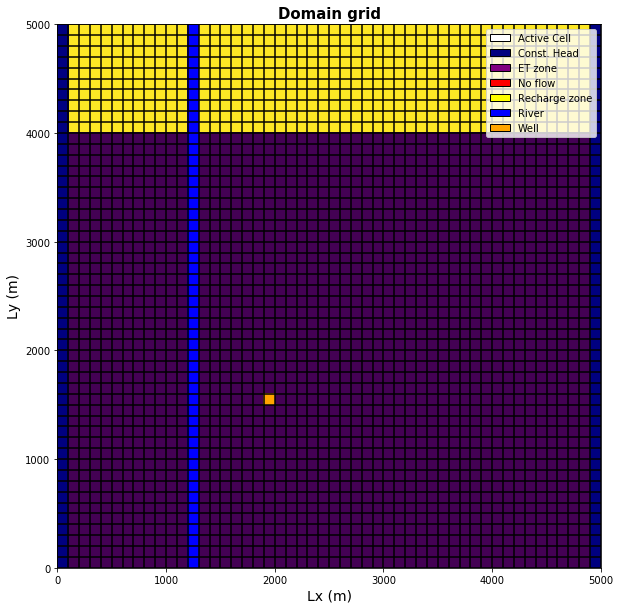

In [3]:
#Set up the plot
fig = plt.figure(figsize=(10, 10))               #create the figure (10x10) 
ax = fig.add_subplot(1, 1, 1, aspect='equal')    #create the axes

## create the map
modelmap = flopy.plot.PlotMapView(model=m)                 #create the PlotMapView class with the model object 
grid = modelmap.plot_grid(colors='black')                  #draw the grid
ET_map = modelmap.plot_array(ET_zone)                      #plot ET array
rech_map = modelmap.plot_array(rech_zone)                  #plot Recharge array
# *Note: because ET and recharge are arrays, they have different inputs and they appear as a color ramp in the map. e.g. if you comment out ET, 
# the recharge will still show yellow and purple. The yellow indicates nonzero values, while purple is zero values 
riv_map = modelmap.plot_bc(ftype='RIV', color='blue')      #plot River in blue (ftype used)
wel_map = modelmap.plot_bc('WEL', color='orange')          #plot Well in orange (ftype not used here, but it still works!)
ibound_map = modelmap.plot_ibound(color_noflow='red', color_ch='navy')  #plot no flow boundaries in red and constant head in navy

## add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)   #label x axis 
plt.ylabel('Ly (m)',fontsize = 14)   #label y axis 
plt.title('Domain grid', fontsize = 15, fontweight = 'bold')  #add title and specify font size/font type
plt.legend(handles=[mp.patches.Patch(color='white',label='Active Cell',ec='black'),  #label Active cells
                    mp.patches.Patch(color='navy',label='Const. Head',ec='black'),   #label Constant head boundary conditions
                    mp.patches.Patch(color='purple',label='ET zone',ec='black'),     #label ET zone (this is everywhere, but the recharge covers it)
                    mp.patches.Patch(color='red',label='No flow',ec='black'),        #label Inactive/no flow cells
                    mp.patches.Patch(color='yellow',label='Recharge zone',ec='black'),  #label Recharge zone
                    mp.patches.Patch(color='blue',label='River',ec='black'),             #label the River
                    mp.patches.Patch(color='orange',label='Well',ec='black')])          #label Well
                   
                    

# **ALWAYS place the plt.savefig function before plt.show, otherwise it will not save**
#plt.savefig('Domaingrid.png', dpi = 400)  #(specify name or path with name, resolution to save at)
plt.show(modelmap)

### 3.2 Contour plot
In a similar vein to the domain grid map, we can plot contours over the domain in a map view. Most commonly, we want to plot the head contours, but you could contour any array. You can plot the results for a specified stress period or all of the stress periods. 

*Note:* The location of the legend is specified in this example and you can read more about bbox_to_anchor [here](https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/).

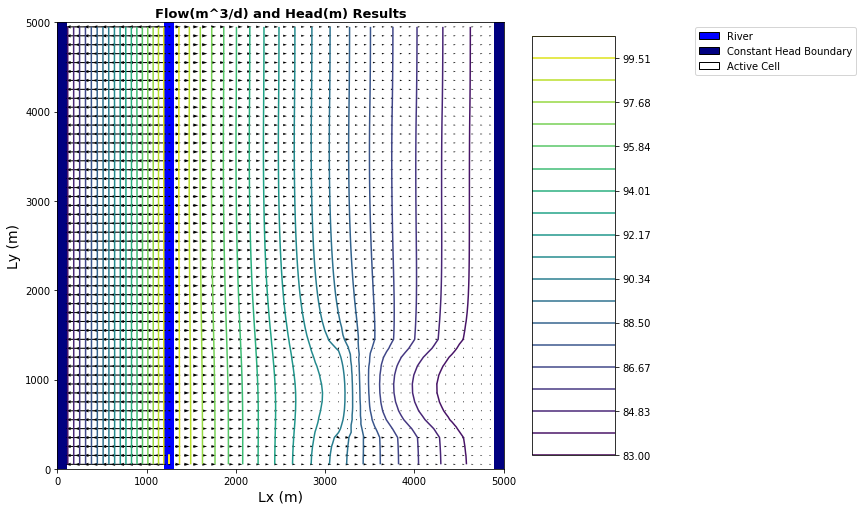

In [4]:
#Plot results for a specified stress period
fig = plt.figure(figsize=(10,10))                    #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)  #use modelmap to attach plot to model
# grid = modelmap.plot_grid()                          #plot model grid (it can make it hard to view the contours)

## adding variable to plot
ibound_map = modelmap.plot_ibound(color_ch='navy')                          #plot boundary conditions
riv_plot = modelmap.plot_bc(ftype='RIV', color='blue')                      #plot river cells
contour_levels = np.linspace(head['sp0'][0].min(),head['sp0'][0].max(),20)  #set contour levels for contouring head, we chose the first timestep in the first stress period
head_contours = modelmap.contour_array(head['sp0'][0], levels=contour_levels)    #create head contours
flows = modelmap.plot_discharge(frf['sp0'][0], fff['sp0'][0], head=head['sp0'])  #create discharge arrows
    
## display parameters
plt.xlabel('Lx (m)',fontsize = 14)  #label the x axis
plt.ylabel('Ly (m)',fontsize = 14)  #label the y axis
plt.title('Flow(m^3/d) and Head(m) Results', fontsize = 13, fontweight = 'bold')              #add a title 
plt.colorbar(head_contours,aspect=5)                                                          #add color bar to right-side
plt.legend(handles=[mp.patches.Patch(color='blue',label='River',ec='black'),                  #label the River
                   mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),  #label Constant head boundary conditions
                   mp.patches.Patch(color='white',label='Active Cell',ec='black')],           #label Active cells
                   bbox_to_anchor=(1.8,1.0))                                                  #create legend, bbox describes where to locate it
# plt.savefig('Contour_w_vectors.png')   
# plt.show(modelmap)


#-------------
# #Plot results for all stress periods
# for i in range(len(times)):                                 #use a for loop to select every timestep in all stress periods   
#     plt.figure(figsize=(10,10))                             #create 10 x 10 figure
#     modelmap = flopy.plot.PlotMapView(model=m, layer=0)     #use modelmap to attach plot to model
#     grid = modelmap.plot_grid()                             #plot model grid
#     riv_plot = modelmap.plot_bc(ftype='RIV', color='blue')  #plot river cells
#     ibound_map = modelmap.plot_ibound(color_ch='navy')      #plot constant head in navy
#     contour_levels = np.linspace(head['sp%s'%i][0].min(),head['sp%s'%i][0].max(),20)         #set contour levels for contouring head, 'sp%s' selects the stress period, %i selects the timestep
#     head_contours = modelmap.contour_array(head['sp%s'%i][0], levels=contour_levels)         #create head contours
#     flows = modelmap.plot_discharge(frf['sp%s'%i][0], fff['sp%s'%i][0], head=head['sp%s'%i]) #create discharge arrows
    
#     ## display parameters
#     plt.xlabel('Lx (m)',fontsize = 14)  #label the x axis
#     plt.ylabel('Ly (m)',fontsize = 14)  #label the y axis
#     plt.title('Flow(m^3/d) and Head(m) Results: Stress Period %s'%(i+1), fontsize = 13, fontweight = 'bold')  #add a title
#     plt.colorbar(head_contours, aspect=5)                                                                     #add color bar to right-side
#     plt.legend(handles=[mp.patches.Patch(color='blue',label='River',ec='black'),                              #label the River
#                    mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),                  #label Constant head boundary conditions
#                    mp.patches.Patch(color='white',label='Active Cell',ec='black')],                           #label Active cells
#                    bbox_to_anchor=(1.8,1.0))                                                                  #create legend
#     plt.show(modelmap)

#### Additional contour plot
This contour plot contains no boundary conditions or flow arrows. It is created with matplotlib contourf(). The documentation is [here](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.contourf.html) and an example is [here](https://www.geeksforgeeks.org/matplotlib-pyplot-contourf-in-python/).

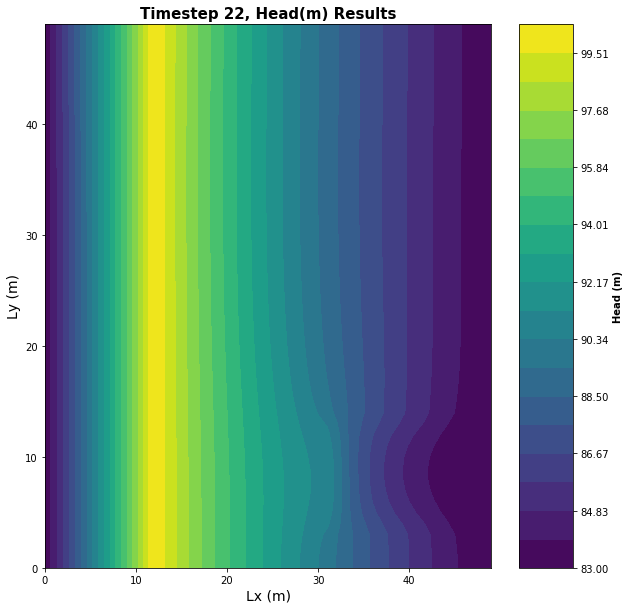

In [5]:
#Plot head contours another way
plt.figure(figsize=(10,10))  #create 10x10 figure 
cf = plt.contourf(np.flipud(head['sp21'][0]),levels=contour_levels)  #contour the timestep 1 data with contour levels specified above

## labelling
plt.xlabel('Lx (m)',fontsize = 14)  #label x axis
plt.ylabel('Ly (m)',fontsize = 14)  #label y axis
plt.title('Timestep 22, Head(m) Results', fontsize = 15, fontweight = 'bold')  #add title
plt.colorbar(cf,aspect=10).set_label('Head (m)',fontsize=10,fontweight='bold')  #add colorbar

# plt.savefig('Contours.png') 
plt.show()

### 3.3 Cross-section plot
We can also view slices of the domain along rows or columns. This is helpful when rivers or streams are involved. See [this notebook](https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb) for further details on plotting cross-sections

*Note: The syntax for plotting is different for steady-state and transient models.*

- Steady-state
> headpc = head[0] 
- Transient
> headpc = head['sp1'] 



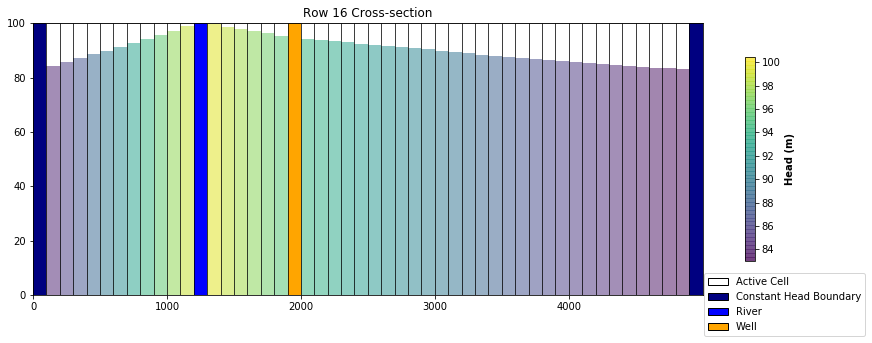

In [6]:
#Cross-section plot
fig = plt.figure(figsize=(15, 5))   #create 15x5 figure 

## add things to plot
xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 34})  #call the x-section plotting, *note use the key 'column' if you want to plot a column instead*
headpc = head['sp1']                                      #select stress period to plot
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)      #make the head values an array to plot
well_patches = xsect.plot_bc('WEL', color='orange')       #plot the well
river_patches = xsect.plot_bc(ftype='RIV', color='blue')  #plot river 
ibound_patches = xsect.plot_ibound(color_noflow='red', color_ch='navy')  #plot the boundary conditions
linecollection = xsect.plot_grid(color='black', lw=0.5)                  #add gridlines

## labelling
plt.title('Row 16 Cross-section')   #add title
cb = plt.colorbar(pc, shrink=0.75)  #set colorbar
cb.set_label('Head (m)',fontsize=10,fontweight='bold')  #label the colorbar
plt.legend(handles=[mp.patches.Patch(color='white',label='Active Cell',ec='black'),            #label Active cells
                    mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),  #label Constant head boundary conditions
                    mp.patches.Patch(color='blue',label='River',ec='black'),                   #label the River
                   mp.patches.Patch(color='orange',label='Well',ec='black')],                  #label the well
                   bbox_to_anchor=(1.25,0.1))                                                  #postion the legend

### 3.4 3D head plot
There are various ways to display the head values across the domain. Above are examples of contours, but they are only in 2D. If we want a better picture of hydraulic head in the subsurface, we can plot in 3D.

The matplotlib documentation has more [information](https://matplotlib.org/3.1.0/tutorials/toolkits/mplot3d.html) and an [example](https://matplotlib.org/3.1.0/gallery/mplot3d/surface3d.html).

Text(0.5, 0.92, 'Head Profile for Timestep 10')

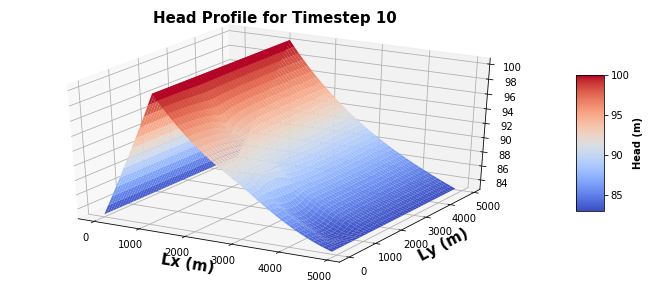

In [7]:
#Plot head over domain in 3D
fig_3d = plt.figure(figsize=(12,5))  #create 12x5 figure
ax = fig_3d.gca(projection='3d')     #create 3D axes

## set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)    #set X array
Y = np.arange(0,Ly,dy)    #set Y array
X, Y = np.meshgrid(X, Y)  #create mesh grid from arrays
Z = np.flipud(head['sp9'][0])  #create Z array (we have to flip the head values because (0,0) in Modflow and Python are different)

## create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, label='head')  #create surface and set its attributes
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')  #create and label the colorbar legend
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')  #label x axis
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')  #label y axis
ax.set_title('Head Profile for Timestep 10', fontsize=15, fontweight='bold')  #add title
# plt.savefig('Head_Surface10.png') 
# plt.show(surf)


#-------------
#Plot head for every timestep
# ## set X, Y, Z variables for 3D plot to be our model domain and head solution
# X = np.arange(0,Lx,dx)   #set X array
# Y = np.arange(0,Ly,dy)   #set Y array
# X, Y = np.meshgrid(X, Y  #create mesh grid from arrays

# ## create a figure for every timestep
# for i in range(len(times)):
#     #create 3d figure
#     fig_3d = plt.figure(figsize=(12,5)) #create a figure 
#     ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
#     Z = np.flipud(head['sp%s'%i][0]) #head matrix is flipped to display properly 

#     # create surface and labels
#     surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #create surface and set its attributes
#     fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #create and label the colorbar legend
#     ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')  #label x axis
#     ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')   #label y axis
#     ax.set_title('Head Surface: Timestep %s'%(i+1), fontsize=15, fontweight='bold')  #add title
#     plt.show(surf)

### 3.5 Line plots
Line plots are the most basic plot used in this class. They can be used to show how hydraulic head varies spatially and temporally. They can also be used to show similar changes in storage, river leakage, ET, and recharge. First, let's plot head along row 25 in timestep 15.

You can change the line style, line color, line size, marker style, and marker size. Some helpful pages can be found below:

- [Color options](https://matplotlib.org/3.2.1/gallery/color/named_colors.html)

- [Marker styles and other info](https://matplotlib.org/2.1.1/api/_as_gen/matplotlib.pyplot.plot.html)

- [General plotting](https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html)

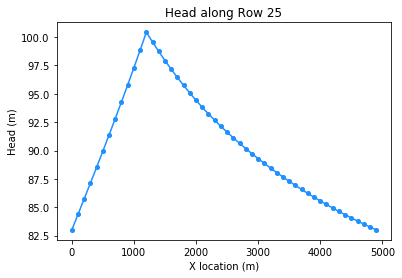

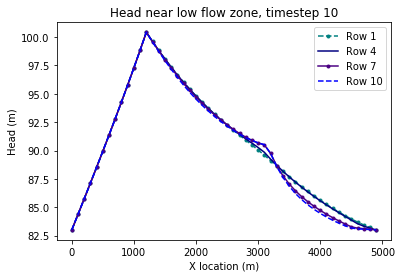

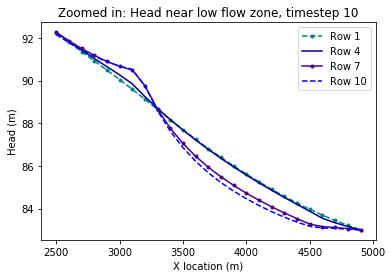

In [8]:
#Plot head across the domain in row 25
basic_head_fig = plt.figure()  #create figure
## set x and y
x=np.arange(0,5000,100)  #specify the domain length (0, 5000) and each step (100)
y=head['sp14'][0][24]    #select timestep 15, row 25

## labelling
plt.plot(x,y,marker='o', color='dodgerblue', markersize=4, linestyle='-')  #specify plot features
plt.xlabel('X location (m)')    #label x axis
plt.ylabel('Head (m)')          #label y axis
plt.title("Head along Row 25")  #add title
# plt.savefig('Head_Transect.png') #save figure as a png


#-------------
#Plot head in timestep 10 near the low flow zone
comparison_fig = plt.figure()   #create first comparison figure
x=np.arange(0,5000,100)  #specify the domain length (0, 5000) and each step (100)

## how to plot the heads we want
plt.plot(x,head['sp9'][0][49], color='teal', marker='o', markersize=3, linestyle='--', label= "Row 1")  #plot head in row 1
plt.plot(x,head['sp9'][0][46], color='navy', markersize=2, linestyle='-',label="Row 4")  #plot head in row 4
plt.plot(x,head['sp9'][0][43], color='indigo', marker='o', markersize=3, linestyle='-', label="Row 7")  #plot head in row 7
plt.plot(x,head['sp9'][0][40], color='blue', markersize=3, linestyle='--', label="Row 10")  #plot head in row 10

## labelling
plt.xlabel('X location (m)')  #label x axis
plt.ylabel('Head (m)')        #label y axis
plt.title("Head near low flow zone, timestep 10")  #add title
plt.legend()  #add legend for each row 


#-------------
#Zoom in on change in head from the low flow zone
comparison_fig2 = plt.figure()  #create second comparison figure
x=np.arange(2500,5000,100)  #change the x distance range we look at

## how to plot the heads we want *Notice the change in syntax when we call the head, 
# we now specify that we want all data in row 26 and on [25:]*
plt.plot(x,head['sp9'][0][49][25:], color='teal', marker='o', markersize=3, linestyle='--', label= "Row 1")  #plot head in row 1
plt.plot(x,head['sp9'][0][46][25:], color='navy', markersize=2, linestyle='-',label="Row 4")  #plot head in row 4
plt.plot(x,head['sp9'][0][43][25:], color='indigo', marker='o', markersize=3, linestyle='-', label="Row 7")  #plot head in row 7
plt.plot(x,head['sp9'][0][40][25:], color='blue', markersize=3, linestyle='--', label="Row 10")  #plot head in row 10

## labelling
plt.xlabel('X location (m)')  #label x axis
plt.ylabel('Head (m)')        #label y axis
plt.title("Zoomed in: Head near low flow zone, timestep 10")  #add title
plt.legend()  #add legend for each row

Now we will plot head in a certain cell over time. Then, we can plot a few different cell IDs to compare them. These plots are side-by-side. The formatting was modified from this [link](https://stackoverflow.com/questions/55663030/plotting-two-heat-maps-side-by-side-in-matplotlib), but the matplotlib documetation on this topic is [here](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html). In this example, the plotting parameters are called via ax.(). The matplotlib documentation gives all the options associated with this plotting method [here](https://matplotlib.org/api/axes_api.html).

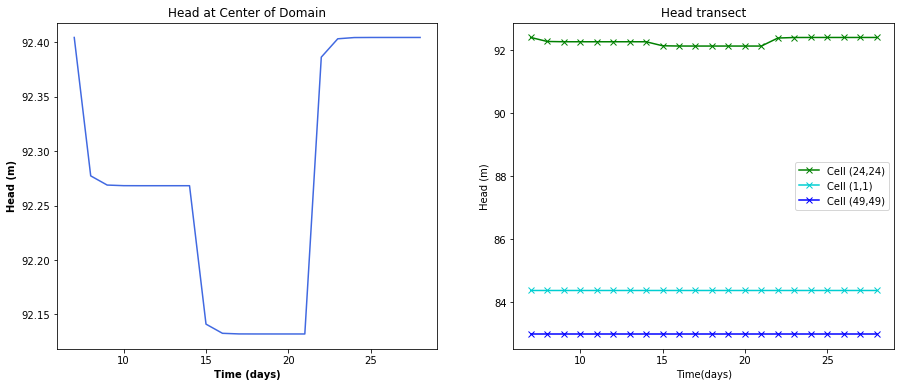

In [9]:
#Plot head at center of the domain and at different cells
## get time series for center cell
cell_id = (0, int(nrow/2) - 1, int(ncol/2)-1)  #cell at the center of the domain
time_series = headobj.get_ts(cell_id)  #get the time series using flopy

## get time series for other cells
cell_id2 = (0, int(nrow) - 49, int(ncol) - 49) #cell at the end of the domain
time_series2 = headobj.get_ts(cell_id2) #get the time series using flopy
cell_id3 = (0, int(nrow) - 1, int(ncol) - 1) #cell at the beginning of domain
time_series3 = headobj.get_ts(cell_id3) #get the time series using flopy
# print('cell_id = ', cell_id1, 'cell_id2 = ', cell_id2,'cell_id3 = ', cell_id3)

## create the figure and subplots
fig, axes = plt.subplots(ncols=2, figsize=(15, 6)) #need 2 columns to show two plots
ax1, ax2 = axes  #create two different axes

## plotting parameters for axis 1
ax1.plot(time_series[:, 0], time_series[:, 1], color='royalblue') #plot the time series for center cell
ax1.set_title("Head at Center of Domain")        #add title to plot 1
ax1.set_xlabel('Time (days)',fontweight='bold')  #label x axis for axis 1, bolded font
ax1.set_ylabel('Head (m)',fontweight='bold')     #label y axis for axis 1, bolded font

## plotting parameters for axis 2
ax2.plot(time_series[:, 0], time_series[:, 1], marker='x', color='green', markersize=6, linestyle='-', label="Cell (24,24)")  #plot timeseries at (24,24)
ax2.plot(time_series2[:, 0], time_series2[:, 1], marker='x', color='darkturquoise', markersize=6, linestyle='-', label="Cell (1,1)")  #plot timeseries at (1,1)
ax2.plot(time_series3[:, 0], time_series3[:, 1], marker='x', color='blue', markersize=6, linestyle='-', label="Cell (49,49)")  #plot timeseries at (49,49)
ax2.set_title('Head transect')  #add title to plot 2
ax2.set_xlabel('Time(days)')    #label x axis for axis 2, unbolded
ax2.set_ylabel('Head (m)')      #label y axis for axis 2, unbolded
ax2.legend()                    #add legend

We can also plot other water budget variables in time. For example, below the leakage is plotted over time. Unsurprisingly, the trend is this plot is the opposite of the head plot above.

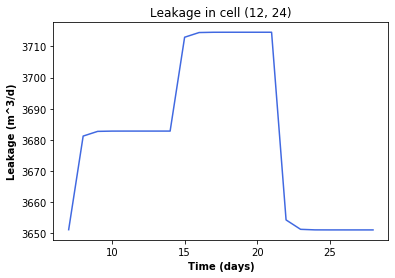

In [10]:
#Plot leakage over time 
## get time series for cell
cell_id = (0, int(nrow/2) - 1, int(ncol/4))  #cell halfway across domain in y(24) and through river in x(12)
time_series = budgobj.get_ts(cell_id, text='RIVER LEAKAGE')  #get the time series using flopy, key word = 'RIVER LEAKAGE'

fig = plt.figure()  #create figure 
plt.plot(time_series[:, 0], time_series[:, 1], color='royalblue')  #plot the time series with a point at each record

## labelling
plt.title("Leakage in cell (12, 24)")            #add title
plt.xlabel('Time (days)',fontweight='bold')      #label x axis, bolded
plt.ylabel('Leakage (m^3/d)',fontweight='bold')  #label x axis, bolded

plt.show()

## 4. Load in particle files

In [11]:
## load in the flow path file
mpname=os.path.join(modelname + '.mp')  #name the model
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

## load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

## make a subset which is all the particles either in stream or in domain depending on locsb
pall = p.get_alldata()  #formerly pwb and ewb
eall = e.get_alldata()

## make a subset which is the particles that end in the river, if the river was not specified in locsb 
riv_locs = []   #create list with locations
riv_nodes = []  #create list with end nodes
for idx in range(0,49):
        riv_locs.append((0, idx,ncol/4))  #layer, row, column
        riv_nodes.append(m.dis.get_node([(0,idx,ncol/4)]))
        
priv = p.get_destination_pathline_data(dest_cells=riv_nodes)  #get pathlines that end at river
eriv = e.get_destination_endpoint_data(dest_cells=riv_nodes)  #get endpoints that end at river

## make a subset which is the particles that end in the well
well_locs = []   #create list with locations
well_nodes = []  #create list with end nodes
well_locs.append((0, 34, 19))  #well location is (0,34,19)
well_nodes.append(m.dis.get_node([(0, 34, 19)]))
        
pwel = p.get_destination_pathline_data(dest_cells=well_nodes)  #get pathlines that end at well
ewel = e.get_destination_endpoint_data(dest_cells=well_nodes)  #get endpoints that end at well

### 4.1 Plot pathlines

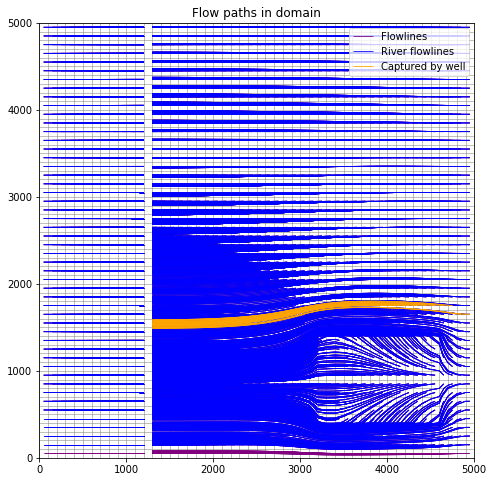

In [12]:
#Plot particles
fig = plt.figure(figsize=(8, 8))  #create figure
ax = fig.add_subplot(1, 1, 1, aspect='equal')  #create an axes object

## create mapview
mm = flopy.plot.PlotMapView(model=m, ax=ax)

## labelling
ax.set_title('Flow paths in domain')  #add title
mm.plot_grid(lw=0.5)  #add grid lines
mm.plot_pathline(pall, layer='all', color='purple', lw=0.8, linestyle='-', label='Flowlines') #,marker='o', markercolor='black', markersize=3, markerevery=5) #plot all particles
mm.plot_pathline(priv, layer='all', color='blue', lw=0.8, linestyle='-', label='River flowlines') #,marker='o', markercolor='black', markersize=3, markerevery=5)  #plot river particles
mm.plot_pathline(pwel, layer='all', color='orange', lw=0.8, linestyle='-', label='Captured by well') #,marker='o', markercolor='black', markersize=3, markerevery=5)  #plot well particles
plt.legend()  #add legend
# plt.savefig('River_flowpaths.png', dpi=600)